In [1]:
# env option: asper_pymc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pandas as pd

In [2]:
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Example Model to Fit

Let's generate and fit the model 


$Y_i = \alpha + \beta_0 X_{1i}  + \beta_1 X_{2i} + e_i,  \quad e_i \sim N(0, \sigma^2)$ 

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

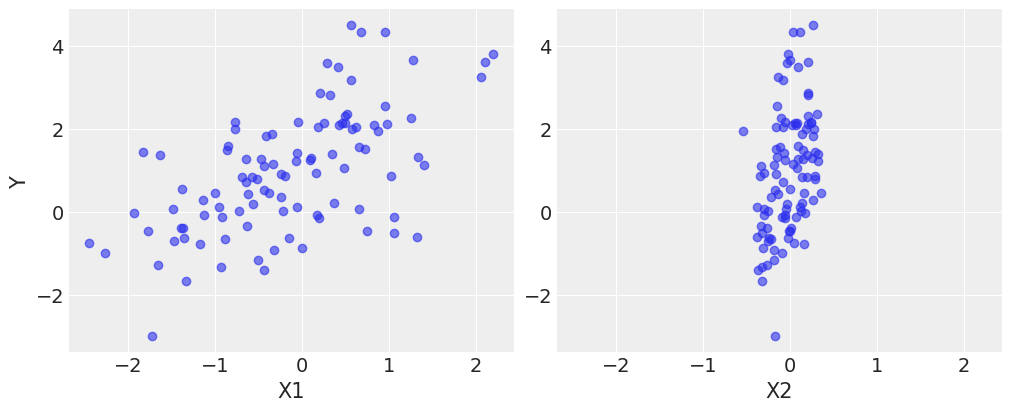

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [5]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.20.1


In [6]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [9]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample(chains=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [10]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [11]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)> Size: 160B
array([[1.29127206, 1.02799047, 1.23835341, 1.21518659, 1.18664354],
       [1.32672653, 1.20305639, 1.22643841, 1.16224468, 1.19666247],
       [1.08780341, 1.15197434, 1.22953078, 1.15908485, 1.19322754],
       [1.05978342, 1.10496058, 1.35954592, 1.30745246, 0.90726483]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 40B 0 1 2 3 4

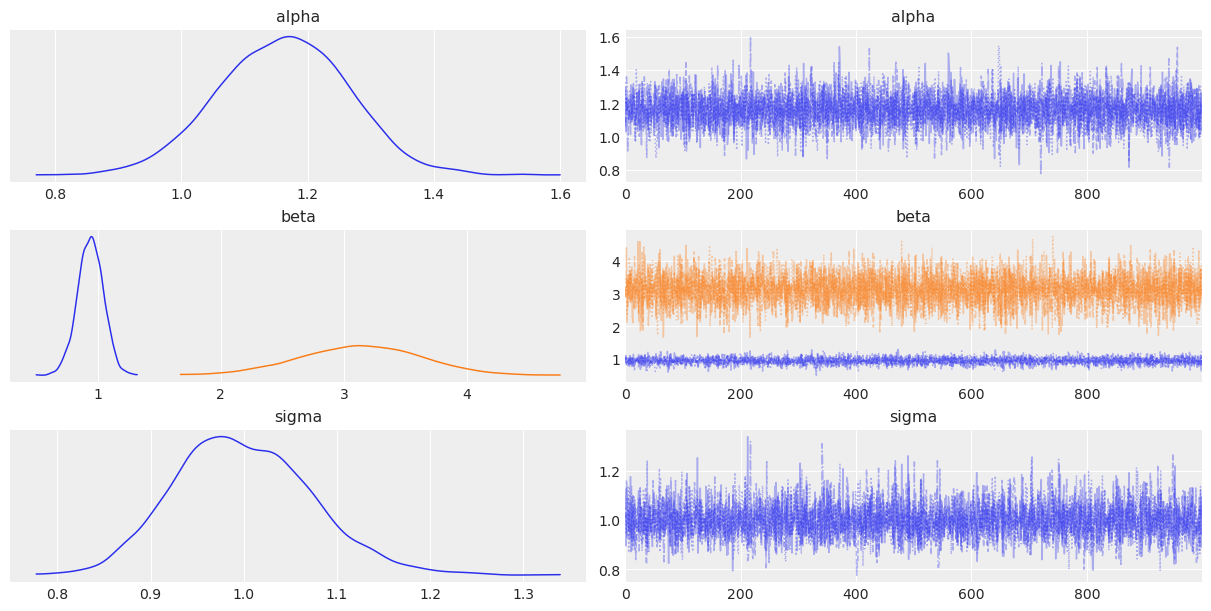

In [12]:
az.plot_trace(idata, combined=True);

In [13]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.16,0.10,0.96,1.34,0.00,0.0,6182.51,3356.80,1.0
beta[0],0.94,0.10,0.74,1.14,0.00,0.0,5314.33,3136.72,1.0
beta[1],3.13,0.48,2.22,4.03,0.01,0.0,5650.08,2972.76,1.0
sigma,1.00,0.07,0.86,1.13,0.00,0.0,4394.72,2993.79,1.0


In [17]:
data

,Disease_A,Disease_B,Disease_C,Time
0,19,32,49,0
1,24,30,46,1
2,22,21,57,2
3,28,31,41,3
4,17,33,50,4
...,...,...,...,...
95,26,30,44,95
96,21,24,55,96
97,21,40,39,97
98,16,35,49,98


In [23]:
import pytensor.tensor as pt

In [ ]:
x = pt.vector()
x = [1,2,3]
pm.math.softmax(x)
pm

Softmax{axis=None}.0


In [43]:
data.head()

,Disease_A,Disease_B,Disease_C,Time
0,19,32,49,0
1,24,30,46,1
2,22,21,57,2
3,28,31,41,3
4,17,33,50,4


In [40]:
# Generate sample data
np.random.seed(42)
n_samples = 100
time = np.arange(n_samples)
disease_counts = np.random.multinomial(100, [0.2, 0.3, 0.5], size=n_samples)

# Create a DataFrame
data = pd.DataFrame(disease_counts, columns=['Disease_A', 'Disease_B', 'Disease_C'])
data['Time'] = time

# Define the model
with pm.Model() as model:
    # Priors for the coefficients
    alpha = pm.Normal('alpha', mu=0, sigma=10, shape=3)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=(3, 1), initval=np.zeros((3, 1)))
    
    # Linear combination
    theta = alpha + pm.math.dot(data['Time'].values[:, None], beta.T)
    
    # Softmax
    #p = pm.Deterministic('p', pm.math.softmax(theta))
    p = pm.math.log(pm.math.sum(pm.math.exp(theta), axis=1))

    # Multinomial likelihood
    obs = pm.Multinomial('obs', n=100, p=pm.math.softmax(theta), observed=disease_counts)
    
    # Inference
    trace = pm.sample(1000, tune=1000, cores=2, init='adapt_diag')

# Plot the results
pm.traceplot(trace)
plt.show()

# Print summary of the trace
print(pm.summary(trace))

Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Output()

ParallelSamplingError: Chain 0 failed with: Bad initial energy: SamplerWarning(kind=<WarningType.BAD_ENERGY: 8>, message='Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:\n[-inf]\n.Try model.debug() to identify parametrization problems.', level='critical', step=0, exec_info=None, extra=None, divergence_point_source=None, divergence_point_dest=None, divergence_info=None)

In [41]:
model.debug()

point={'alpha': array([0., 0., 0.]), 'beta': array([[0.],
       [0.],
       [0.]])}

The variable obs has the following parameters:
0: [100] [id A] <Vector(int8, shape=(1,))>
1: Softmax{axis=None} [id B] <Matrix(float64, shape=(100, 3))>
 └─ Add [id C] <Matrix(float64, shape=(100, 3))>
    ├─ ExpandDims{axis=0} [id D] <Matrix(float64, shape=(1, 3))>
    │  └─ alpha [id E] <Vector(float64, shape=(3,))>
    └─ dot [id F] <Matrix(float64, shape=(100, 3))>
       ├─ [[ 0] [ 1] ... [98] [99]] [id G] <Matrix(int64, shape=(100, 1))>
       └─ Transpose{axes=[1, 0]} [id H] <Matrix(float64, shape=(1, 3))> 'beta.T'
          └─ beta [id I] <Matrix(float64, shape=(3, 1))>
The parameters evaluate to:
0: [100]
1: [[0.00333333 0.00333333 0.00333333]
 [0.00333333 0.00333333 0.00333333]
 [0.00333333 0.00333333 0.00333333]
 [0.00333333 0.00333333 0.00333333]
 [0.00333333 0.00333333 0.00333333]
 [0.00333333 0.00333333 0.00333333]
 [0.00333333 0.00333333 0.00333333]
 [0.00333333 0.00333333 0.00333333]
